# JET-ML MLBT vs MMAT – **v3.2 (GPU-ready, Mixed Precision, XLA)**

What’s new:
- Detects GPUs and enables **memory growth** to avoid OOM spikes.
- Optional **XLA** compilation and **mixed precision (fp16)** for speedups on supported GPUs.
- Uses `tf.distribute` strategy (multi-GPU ready). 
- Ensures the final output is computed in float32 when using mixed precision.

You can still flip all training toggles (model, resize, normalization, etc.).


In [17]:
# ============ 0) Global toggles ============
# Training pipeline options
AUGMENT = False              # True / False
MODEL_CHOICE = "Small32CNN"       # "VGG16" or "Small32CNN"
RESIZE_METHOD = "nearest"    # "nearest" or "bilinear" (VGG16 only)
NORM_MODE = "zscore"         # "imagenet" or "zscore"
VGG_WEIGHTS = "imagenet"     # "imagenet" or None
UNFREEZE_LAYERS = 12         # top-N VGG layers to unfreeze during fine-tune
HEAD_LR = 1e-3               # learning rate for head-only training
FT_LR = 3e-6                 # learning rate for fine-tuning
EPOCHS_HEAD = 30             # epochs for head-only
EPOCHS_FT = 5               # epochs for fine-tune
BATCH = 32
IMG_SIZE = 224               # for VGG16 path
USE_GROUPED_SPLIT = True     # stratify by (module, alpha_s, Q0)
USE_CLASS_WEIGHTS = True     # re-balance classes if needed
RUN_BASELINE = True          # logistic regression baseline
FINE_TUNE = False             # run fine-tuning phase if using VGG16
SAVE_BEST_PATH = "mlbt_mmat_v3p2_best.keras"

# GPU / performance toggles
ENABLE_XLA = True            # turn on XLA JIT if GPU present
USE_MIXED_PRECISION = True   # set global policy to 'mixed_float16' if GPU present
USE_DISTRIBUTED = True       # use MirroredStrategy if multiple GPUs


In [18]:
# 1) Clean logs + imports
import os
os.environ["TERM"] = "dumb"
os.environ["PYTHONIOENCODING"] = "UTF-8"
print("TERM =", os.environ.get("TERM"))

import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from collections import Counter

# Keras bits
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import matplotlib.pyplot as plt

print("TensorFlow:", tf.__version__)
AUTOTUNE = tf.data.AUTOTUNE


TERM = dumb
TensorFlow: 2.17.0


In [19]:
# 1.1) GPU setup (memory growth, XLA, mixed precision, strategy)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except Exception as e:
        print("Could not set memory growth:", e)

    if ENABLE_XLA:
        try:
            tf.config.optimizer.set_jit(True)  # Enable XLA
            print("XLA JIT enabled")
        except Exception as e:
            print("Could not enable XLA:", e)

    if USE_MIXED_PRECISION:
        try:
            from tensorflow.keras import mixed_precision
            mixed_precision.set_global_policy('mixed_float16')
            print("Mixed precision policy set to:", mixed_precision.global_policy().name)
        except Exception as e:
            print("Could not set mixed precision:", e)

    if USE_DISTRIBUTED and len(gpus) > 1:
        strategy = tf.distribute.MirroredStrategy()
        print(f"Using MirroredStrategy on {strategy.num_replicas_in_sync} replicas")
    else:
        strategy = tf.distribute.get_strategy()
        print("Using default strategy (single GPU or CPU)")
else:
    strategy = tf.distribute.get_strategy()
    print("No GPU detected; using default (CPU) strategy")

print("GPUs detected:", gpus)
try:
    from tensorflow.keras import mixed_precision
    print("Current dtype policy:", mixed_precision.global_policy().name)
except Exception:
    pass


XLA JIT enabled
Mixed precision policy set to: mixed_float16
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')
Using MirroredStrategy on 8 replicas
GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:4', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:5', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:6', device_

In [20]:
# 2) Load the dataset
pkl_path = "jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_100000_shuffled.pkl"
with open(pkl_path, "rb") as f:
    X, y = pickle.load(f)

X = np.asarray(X)     # (N, 32, 32) float
y = np.asarray(y)     # (N, 3) strings: (module, alpha_s, Q0)

modules = y[:,0]                       # "MLBT" or "MMAT"
classes = (modules == "MLBT").astype(np.int32)  # 1=MLBT, 0=MMAT

alphas = y[:,1].astype(str)
q0s    = y[:,2].astype(str)

print("X shape:", X.shape)
print("Module counts:", Counter(modules))
print("Value ranges:", float(np.min(X)), "to", float(np.max(X)))


X shape: (100000, 32, 32)
Module counts: Counter({'MMAT': 50180, 'MLBT': 49820})
Value ranges: 0.0 to 94.01920000000001


In [21]:
# 3) Train/Val split (optionally grouped by module+alpha+Q0)
if USE_GROUPED_SPLIT:
    groups = np.array([f"{m}_{a}_{q}" for m,a,q in zip(modules, alphas, q0s)])
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_idx, val_idx = next(sss.split(X, groups))
else:
    train_idx, val_idx = train_test_split(
        np.arange(len(X)), test_size=0.2, random_state=42, stratify=classes
    )

X_train, X_val = X[train_idx], X[val_idx]
y_train, y_val = classes[train_idx], classes[val_idx]
mods_train = modules[train_idx]; mods_val = modules[val_idx]
a_train, a_val = alphas[train_idx], alphas[val_idx]
q_train, q_val = q0s[train_idx], q0s[val_idx]

print("Train counts:", Counter(y_train), "| Val counts:", Counter(y_val))


Train counts: Counter({0: 40144, 1: 39856}) | Val counts: Counter({0: 10036, 1: 9964})


In [22]:
# 4) Class weights (optional)
if USE_CLASS_WEIGHTS:
    from sklearn.utils.class_weight import compute_class_weight
    uniq = np.unique(y_train)
    cw = compute_class_weight(class_weight="balanced", classes=uniq, y=y_train)
    CLASS_WEIGHT = {int(k): float(v) for k,v in zip(uniq, cw)}
else:
    CLASS_WEIGHT = None
print("Class weights:", CLASS_WEIGHT)


Class weights: {0: 0.9964129135113591, 1: 1.0036130068245686}


In [23]:
# 5) Normalization helpers
SCALE_TO_255 = (float(np.max(X_train)) <= 1.5)  # approximate [0,1]
MEAN = float(np.mean(X_train))
STD  = float(np.std(X_train) + 1e-8)
print("SCALE_TO_255:", SCALE_TO_255, "| MEAN/STD:", MEAN, STD)

def resize_3ch(x):
    x = tf.expand_dims(x, -1)         # (H,W,1)
    x = tf.repeat(x, 3, -1)           # (H,W,3)
    method = "nearest" if RESIZE_METHOD == "nearest" else "bilinear"
    x = tf.image.resize(x, (IMG_SIZE, IMG_SIZE), method=method)
    x = tf.cast(x, tf.float32)
    return x

def preprocess_vgg(x):
    x = resize_3ch(x)
    if NORM_MODE == "imagenet":
        x = x * 255.0 if SCALE_TO_255 else x
        x = preprocess_input(x)
    else:
        x = (x - MEAN) / STD
    return x

def preprocess_32x32(x):
    x = tf.expand_dims(x, -1)  # (32,32,1)
    x = tf.cast(x, tf.float32)
    if NORM_MODE == "imagenet":
        x = x * 255.0 if SCALE_TO_255 else x
    else:
        x = (x - MEAN) / STD
    return x


SCALE_TO_255: False | MEAN/STD: 0.09094801629376666 1.234970399291405


In [24]:
# 6) tf.data datasets
def make_ds(X_arr, y_arr, training=True):
    if MODEL_CHOICE == "VGG16":
        def _map(x, y): return preprocess_vgg(x), y
    else:
        def _map(x, y): return preprocess_32x32(x), y

    ds = tf.data.Dataset.from_tensor_slices((X_arr, y_arr)).map(_map, num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.shuffle(1024)
        if AUGMENT and MODEL_CHOICE == "VGG16":
            aug = tf.keras.Sequential([
                layers.RandomFlip("horizontal"),
                layers.RandomRotation(0.05),
                layers.RandomZoom(0.1),
            ])
            def _aug(x, y): return aug(x), y
            ds = ds.map(_aug, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH).prefetch(AUTOTUNE)
    return ds

train_ds = make_ds(X_train, y_train, training=True)
val_ds   = make_ds(X_val,   y_val,   training=False)


In [25]:
# 7) Baseline logistic regression
if RUN_BASELINE:
    from sklearn.linear_model import LogisticRegression
    Xtr_flat = X_train.reshape((X_train.shape[0], -1))
    Xva_flat = X_val.reshape((X_val.shape[0], -1))
    if NORM_MODE == "imagenet" and not SCALE_TO_255:
        scale = float(np.max(X_train))
        Xtr_bl, Xva_bl = Xtr_flat/scale, Xva_flat/scale
    else:
        Xtr_bl, Xva_bl = Xtr_flat, Xva_flat
    lr = LogisticRegression(max_iter=2000, class_weight="balanced" if USE_CLASS_WEIGHTS else None)
    lr.fit(Xtr_bl, y_train)
    y_pred_bl = lr.predict(Xva_bl)
    print("Baseline logistic accuracy:", accuracy_score(y_val, y_pred_bl))


Baseline logistic accuracy: 0.86455


In [26]:
# 8) Model builders (ensure float32 output when using mixed precision)
def float32_head(x):
    # Ensures final dense runs in float32 for numerical stability with mixed precision
    x = layers.Dense(1, activation="sigmoid", dtype="float32")(x)
    return x

def build_vgg16():
    base = VGG16(include_top=False, weights=VGG_WEIGHTS,
                 input_shape=(IMG_SIZE, IMG_SIZE, 3))
    for layer in base.layers:
        layer.trainable = False

    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)

    # smaller, more stable head
    x = layers.Dense(
        64,
        activation="relu",
        kernel_regularizer=tf.keras.regularizers.l2(1e-4)
    )(x)
    x = layers.Dropout(0.3)(x)

    # ensure float32 output if using mixed precision
    outputs = layers.Dense(1, activation="sigmoid", dtype="float32")(x)

    model = Model(inputs, outputs)
    return model, base


from tensorflow.keras import layers, Model

def conv_bn_relu(x, filters, kernel_size=3, strides=1):
    x = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        padding="same",
        use_bias=False,
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x

def residual_block(x, filters, stride=1):
    """Simple pre-activation-ish residual block for 32x32 inputs."""
    shortcut = x

    # Main path
    y = conv_bn_relu(x, filters, kernel_size=3, strides=stride)
    y = layers.Conv2D(
        filters,
        kernel_size=3,
        strides=1,
        padding="same",
        use_bias=False,
    )(y)
    y = layers.BatchNormalization()(y)

    # Match shortcut if needed
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(
            filters,
            kernel_size=1,
            strides=stride,
            padding="same",
            use_bias=False,
        )(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    out = layers.Add()([y, shortcut])
    out = layers.Activation("relu")(out)
    return out

def build_small32():
    """
    Jet-optimized 32x32 CNN:
      - 3 stages of residual blocks
      - global average pooling
      - small dense head
    """
    inputs = layers.Input(shape=(32, 32, 1))

    # Stem
    x = conv_bn_relu(inputs, 32, kernel_size=3, strides=1)

    # Stage 1: 32 filters, no downsample
    x = residual_block(x, 32, stride=1)
    x = residual_block(x, 32, stride=1)

    # Stage 2: 64 filters, downsample
    x = residual_block(x, 64, stride=2)
    x = residual_block(x, 64, stride=1)

    # Stage 3: 128 filters, downsample
    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128, stride=1)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    # Sigmoid output; force float32 if using mixed precision
    outputs = layers.Dense(1, activation="sigmoid", dtype="float32")(x)

    model = Model(inputs, outputs)
    return model



In [27]:
# 9) Compile + train (head) under strategy.scope()
with strategy.scope():
    if MODEL_CHOICE == "VGG16":
        model, base = build_vgg16()
    else:
        model = build_small32()

    model.compile(optimizer=tf.keras.optimizers.Adam(HEAD_LR),
                  loss="binary_crossentropy",
                  metrics=["accuracy", tf.keras.metrics.AUC(name="auc")])

cbs = [
    ModelCheckpoint(
        SAVE_BEST_PATH,
        monitor="val_auc",
        mode="max",
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor="val_auc",
        mode="max",
        patience=5,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,
        verbose=1,
        min_lr=1e-6
    ),
]


history = model.fit(
    train_ds,
    epochs=EPOCHS_HEAD,
    validation_data=val_ds,
    callbacks=cbs,
    verbose=1,
    class_weight={0:1.0, 1:1.0} if CLASS_WEIGHT is None else CLASS_WEIGHT
)


Epoch 1/30
INFO:tensorflow:Collective all_reduce tensors: 49 all_reduces, num_devices = 8, group_size = 8, implementation = CommunicationImplementation.NCCL, num_packs = 1


2025-11-14 03:58:22.089795: E tensorflow/core/common_runtime/base_collective_executor.cc:248] BaseCollectiveExecutor::StartAbort INVALID_ARGUMENT: Shape mismatch in the collective instance 100. Op at device /job:localhost/replica:0/task:0/device:GPU:0 expected shape [703073] but another member in the group expected shape [32897]. This is likely due to different input shapes at different members of the collective op.
2025-11-14 03:58:22.309728: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3385433802457953156
2025-11-14 03:58:22.309787: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17086860303677343705
2025-11-14 03:58:22.309807: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2520366704648502952
2025-11-14 03:58:22.309827: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 110

InvalidArgumentError: Graph execution error:

Detected at node cond/adam/CollectiveReduceV2_7 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/opt/miniforge3/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/opt/miniforge3/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/opt/miniforge3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/opt/miniforge3/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 211, in start

  File "/opt/miniforge3/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/opt/miniforge3/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/opt/miniforge3/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/opt/miniforge3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 519, in dispatch_queue

  File "/opt/miniforge3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 508, in process_one

  File "/opt/miniforge3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 400, in dispatch_shell

  File "/opt/miniforge3/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 368, in execute_request

  File "/opt/miniforge3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 767, in execute_request

  File "/opt/miniforge3/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 455, in do_execute

  File "/opt/miniforge3/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 577, in run_cell

  File "/opt/miniforge3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3116, in run_cell

  File "/opt/miniforge3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3171, in _run_cell

  File "/opt/miniforge3/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/opt/miniforge3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3394, in run_cell_async

  File "/opt/miniforge3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3639, in run_ast_nodes

  File "/opt/miniforge3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3699, in run_code

  File "/tmp/ipykernel_4081890/3488012756.py", line 36, in <module>

  File "/opt/miniforge3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/miniforge3/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 377, in fit

  File "/opt/miniforge3/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 220, in function

  File "/opt/miniforge3/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 133, in multi_step_on_iterator

  File "/opt/miniforge3/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 114, in one_step_on_data

  File "/opt/miniforge3/lib/python3.11/site-packages/keras/src/optimizers/loss_scale_optimizer.py", line 254, in _handle_cross_replica

  File "/opt/miniforge3/lib/python3.11/site-packages/keras/src/ops/core.py", line 1041, in cond

  File "/opt/miniforge3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/miniforge3/lib/python3.11/site-packages/keras/src/ops/core.py", line 995, in __call__

  File "/opt/miniforge3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/opt/miniforge3/lib/python3.11/site-packages/keras/src/ops/core.py", line 987, in call_fn

  File "/opt/miniforge3/lib/python3.11/site-packages/keras/src/ops/core.py", line 1001, in call

  File "/opt/miniforge3/lib/python3.11/site-packages/keras/src/backend/tensorflow/core.py", line 256, in cond

  File "/opt/miniforge3/lib/python3.11/site-packages/keras/src/optimizers/loss_scale_optimizer.py", line 245, in apply_fn

Collective ops is aborted by: Shape mismatch in the collective instance 100. Op at device /job:localhost/replica:0/task:0/device:GPU:0 expected shape [703073] but another member in the group expected shape [32897]. This is likely due to different input shapes at different members of the collective op.
The error could be from a previous operation. Restart your program to reset.
	 [[{{node cond/adam/CollectiveReduceV2_7}}]] [Op:__inference_multi_step_on_iterator_1479680]

In [ ]:
# 10) Optional fine-tuning for VGG16 (within scope)
if MODEL_CHOICE == "VGG16" and FINE_TUNE:
    with strategy.scope():
        for layer in base.layers[-UNFREEZE_LAYERS:]:
            layer.trainable = True
        model.compile(optimizer=tf.keras.optimizers.Adam(FT_LR),
                      loss="binary_crossentropy",
                      metrics=["accuracy", tf.keras.metrics.AUC(name="auc")])
    history_ft = model.fit(
        train_ds,
        epochs=EPOCHS_FT,
        validation_data=val_ds,
        callbacks=cbs,
        verbose=1,
        class_weight={0:1.0, 1:1.0} if CLASS_WEIGHT is None else CLASS_WEIGHT
    )


Epoch 1/5
INFO:tensorflow:Collective all_reduce tensors: 22 all_reduces, num_devices = 8, group_size = 8, implementation = CommunicationImplementation.NCCL, num_packs = 1


2025-11-14 03:19:42.295555: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng19{k2=0} for conv (f16[512,3,3,512]{3,2,1,0}, u8[0]{0}) custom-call(f16[4,28,28,512]{3,2,1,0}, f16[4,28,28,512]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2025-11-14 03:19:42.602829: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.307461605s
Trying algorithm eng19{k2=0} for conv (f16[512,3,3,512]{3,2,1,0}, u8[0]{0}) custom-call(f16[4,28,28,512]{3,2,1,0}, f16[4,28,28,512]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","w

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.8030 - auc: 0.8833 - loss: 0.4292
Epoch 1: val_auc improved from 0.85691 to 0.95018, saving model to mlbt_mmat_v3p2_best.keras
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 556s 204ms/step - accuracy: 0.8030 - auc: 0.8833 - loss: 0.4291 - val_accuracy: 0.8784 - val_auc: 0.9502 - val_loss: 0.3001 - learning_rate: 3.0000e-06
Epoch 2/5
2499/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.8736 - auc: 0.9376 - loss: nan

2025-11-14 03:35:46.560415: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]



Epoch 2: val_auc did not improve from 0.95018
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 466s 186ms/step - accuracy: 0.8736 - auc: 0.9376 - loss: nan - val_accuracy: 0.5018 - val_auc: 0.5000 - val_loss: nan - learning_rate: 3.0000e-06
Epoch 3/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5023 - auc: 0.5000 - loss: nan
Epoch 3: val_auc did not improve from 0.95018
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 139s 55ms/step - accuracy: 0.5023 - auc: 0.5000 - loss: nan - val_accuracy: 0.5018 - val_auc: 0.5000 - val_loss: nan - learning_rate: 3.0000e-06
Epoch 4/5
2499/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5027 - auc: 0.5000 - loss: nan
Epoch 4: val_auc did not improve from 0.95018

Epoch 4: ReduceLROnPlateau reducing learning rate to 1.500000053056283e-06.
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 140s 56ms/step - accuracy: 0.5027 - auc: 0.5000 - loss: nan - val_accuracy: 0.5018 - val_auc: 0.5000 - val_loss: nan - learning_rate: 3.0000e-06
Epoch 5/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - a

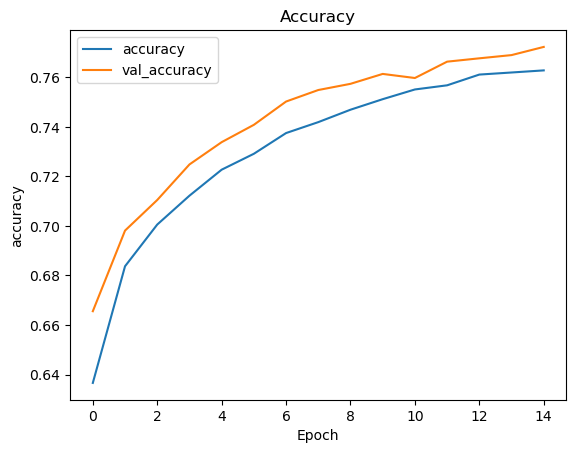

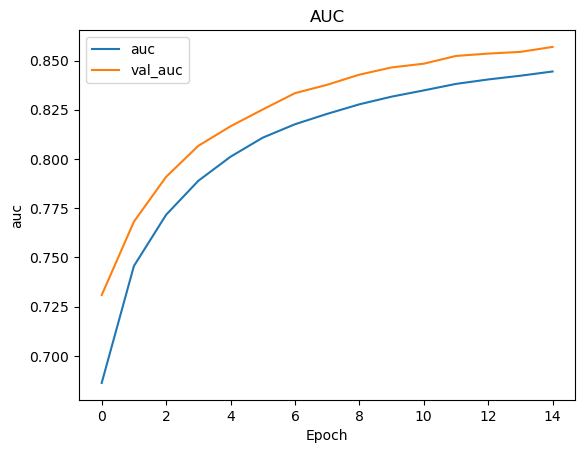

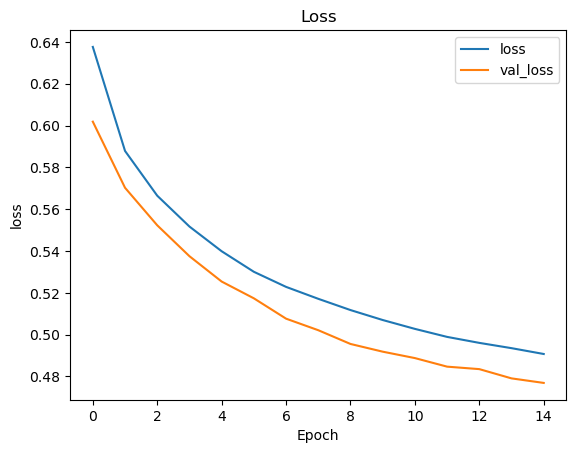

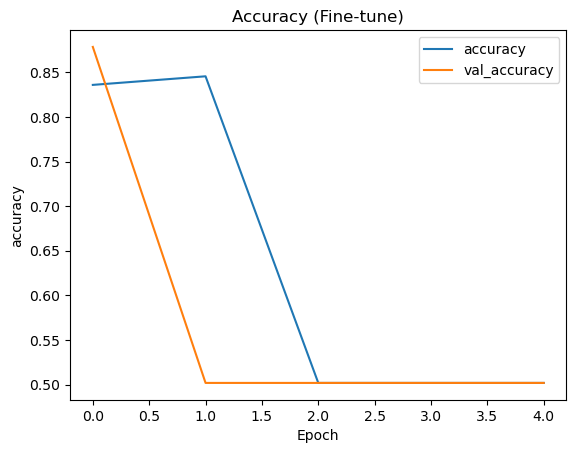

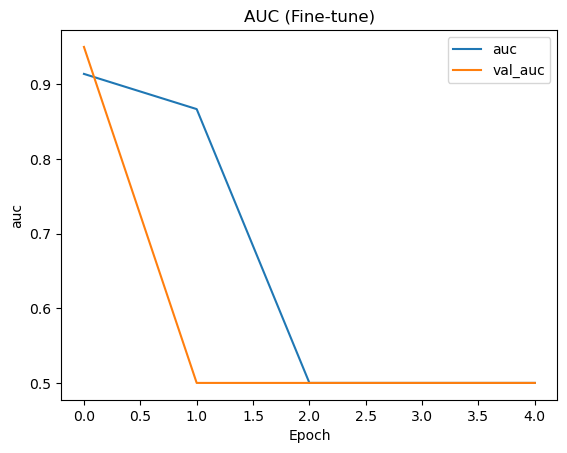

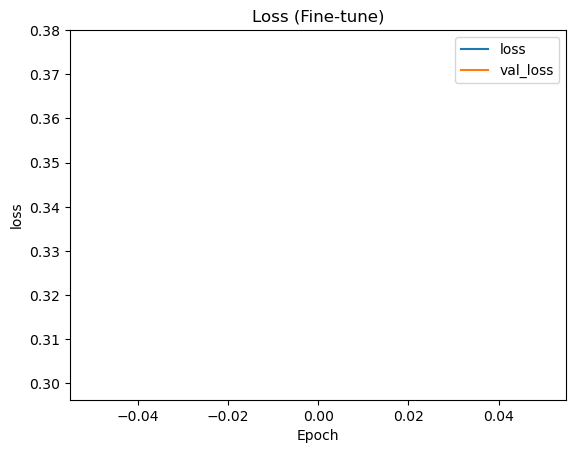

In [ ]:
# 11) Training curves (accuracy, AUC, loss)
def plot_metric(hist, key, val_key=None, title=None):
    if val_key is None:
        val_key = "val_" + key
    h = hist.history
    if key in h and val_key in h:
        plt.figure()
        plt.plot(h[key], label=key)
        plt.plot(h[val_key], label=val_key)
        plt.title(title if title else key)
        plt.xlabel("Epoch")
        plt.ylabel(key)
        plt.legend()
        plt.show()

plot_metric(history, "accuracy", "val_accuracy", "Accuracy")
plot_metric(history, "auc", "val_auc", "AUC")
plot_metric(history, "loss", "val_loss", "Loss")

try:
    plot_metric(history_ft, "accuracy", "val_accuracy", "Accuracy (Fine-tune)")
    plot_metric(history_ft, "auc", "val_auc", "AUC (Fine-tune)")
    plot_metric(history_ft, "loss", "val_loss", "Loss (Fine-tune)")
except NameError:
    pass


625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 38ms/step


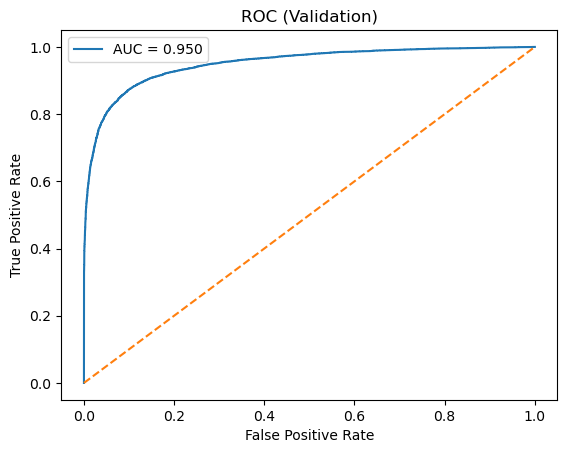

In [ ]:
# 12) ROC curve (validation)
y_prob = model.predict(val_ds).ravel()
fpr, tpr, _ = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC (Validation)")
plt.legend()
plt.show()


Confusion matrix:
 [[9497  539]
 [1892 8072]]


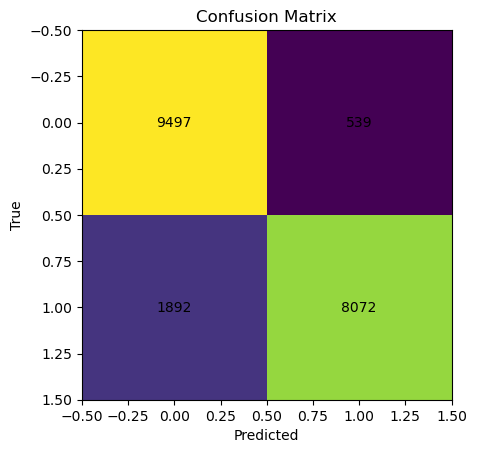


Classification report (1=MLBT, 0=MMAT):
              precision    recall  f1-score   support

        MMAT       0.83      0.95      0.89     10036
        MLBT       0.94      0.81      0.87      9964

    accuracy                           0.88     20000
   macro avg       0.89      0.88      0.88     20000
weighted avg       0.89      0.88      0.88     20000



In [ ]:
# 13) Confusion matrix & report
y_pred = (y_prob >= 0.5).astype(int)
cm = confusion_matrix(y_val, y_pred)
print("Confusion matrix:\n", cm)

plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")
plt.show()

print("\nClassification report (1=MLBT, 0=MMAT):")
print(classification_report(y_val, y_pred, target_names=["MMAT", "MLBT"]))


In [ ]:
# === Save the trained model ===
save_path = "mlbt_mmat_final_model.keras"   # or .h5 if you prefer legacy format
model.save(save_path)
print(f"Model saved to: {save_path}")


Model saved to: mlbt_mmat_final_model.keras
